In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

In [2]:
SEED = 42

In [3]:
spark = SparkSession.builder.appName("BigData projekt model").getOrCreate()

In [4]:
df = spark.read.csv("data/mountains_vs_beaches_preferences.csv",
                    sep=';',
                    inferSchema=True,
                    header=True)

In [5]:
print("Schema:")
df.printSchema()

Schema:
root
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Travel_Frequency: integer (nullable = true)
 |-- Preferred_Activities: string (nullable = true)
 |-- Vacation_Budget: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Proximity_to_Mountains: integer (nullable = true)
 |-- Proximity_to_Beaches: integer (nullable = true)
 |-- Favorite_Season: string (nullable = true)
 |-- Pets: integer (nullable = true)
 |-- Environmental_Concerns: integer (nullable = true)
 |-- Preference: integer (nullable = true)



In [11]:
# Indeksowanie kolumn typu string (zakodowanie ich na wartości numeryczne)
string_cols = [field.name for field in df.schema.fields if str(field.dataType) == 'StringType()']
print(string_cols)

['Gender', 'Education_Level', 'Preferred_Activities', 'Location', 'Favorite_Season']


In [24]:
for col in string_cols:
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}_indexed")
    df = indexer.fit(df).transform(df)

In [25]:
# Sprawdzenie schematu danych
print("Schema:")
df.printSchema()


Schema:
root
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Travel_Frequency: integer (nullable = true)
 |-- Preferred_Activities: string (nullable = true)
 |-- Vacation_Budget: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Proximity_to_Mountains: integer (nullable = true)
 |-- Proximity_to_Beaches: integer (nullable = true)
 |-- Favorite_Season: string (nullable = true)
 |-- Pets: integer (nullable = true)
 |-- Environmental_Concerns: integer (nullable = true)
 |-- Preference: integer (nullable = true)
 |-- Gender_indexed: double (nullable = false)
 |-- Education_Level_indexed: double (nullable = false)
 |-- Preferred_Activities_indexed: double (nullable = false)
 |-- Location_indexed: double (nullable = false)
 |-- Favorite_Season_indexed: double (nullable = false)



In [14]:
# Zbiór cech do modelu
feature_columns = [f"{col}_indexed" if col in string_cols else col for col in df.columns if col != "Preference"]
print(feature_columns)

['Age', 'Gender_indexed', 'Income', 'Education_Level_indexed', 'Travel_Frequency', 'Preferred_Activities_indexed', 'Vacation_Budget', 'Location_indexed', 'Proximity_to_Mountains', 'Proximity_to_Beaches', 'Favorite_Season_indexed', 'Pets', 'Environmental_Concerns']


In [16]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
print(assembler)

VectorAssembler_ce9728e31c94


In [19]:
# Random Forest Classifier
rf = RandomForestClassifier(labelCol="Preference", featuresCol="features", seed=SEED)

In [20]:
# Pipeline: indeksowanie + łączenie cech + model
pipeline = Pipeline(stages=[assembler, rf])

In [27]:
# Podział danych na zbiór treningowy i testowy
train, test = df.randomSplit([0.7, 0.3], SEED)

In [28]:
# Trening modelu
model = pipeline.fit(train)

In [29]:
# Ewaluacja modelu
predictions = model.transform(test)
predictions.select("features", "Preference", "prediction").show()

+--------------------+----------+----------+
|            features|Preference|prediction|
+--------------------+----------+----------+
|[18.0,0.0,20312.0...|         0|       0.0|
|[18.0,0.0,20848.0...|         0|       0.0|
|[18.0,0.0,21186.0...|         1|       1.0|
|[18.0,0.0,21583.0...|         0|       0.0|
|[18.0,0.0,23403.0...|         0|       0.0|
|[18.0,0.0,23829.0...|         0|       0.0|
|[18.0,0.0,25711.0...|         1|       1.0|
|[18.0,0.0,26859.0...|         1|       1.0|
|(13,[0,2,6,7,8,9,...|         0|       0.0|
|[18.0,0.0,27138.0...|         0|       0.0|
|[18.0,0.0,27140.0...|         0|       0.0|
|[18.0,0.0,27796.0...|         0|       0.0|
|[18.0,0.0,27901.0...|         0|       0.0|
|[18.0,0.0,27971.0...|         0|       0.0|
|[18.0,0.0,28668.0...|         0|       0.0|
|[18.0,0.0,29675.0...|         0|       0.0|
|[18.0,0.0,29772.0...|         0|       0.0|
|[18.0,0.0,31168.0...|         1|       1.0|
|[18.0,0.0,31451.0...|         0|       0.0|
|[18.0,0.0

In [44]:
pred_result = predictions.groupBy('Preference', 'prediction').count()
pred_result.show()

+----------+----------+-----+
|Preference|prediction|count|
+----------+----------+-----+
|         1|       0.0|  578|
|         0|       0.0|11700|
|         1|       1.0| 3358|
|         0|       1.0|   57|
+----------+----------+-----+



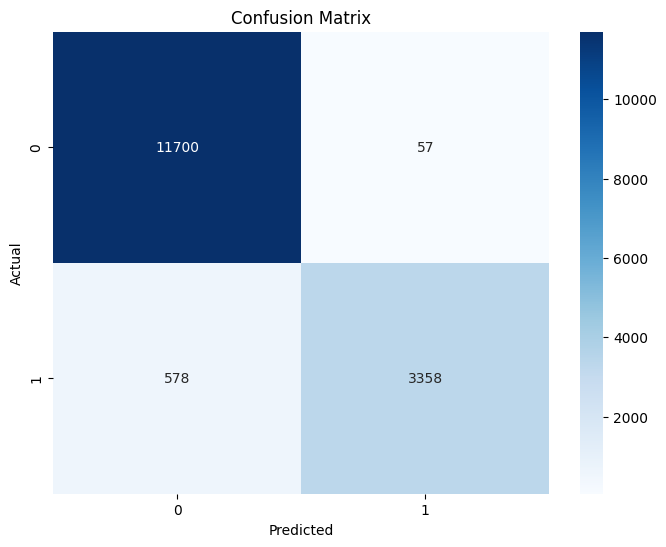

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

matrix = np.zeros((len(labels), len(labels)))
for _, row in conf_matrix.iterrows():
    true_label = int(row["Preference"])
    pred_label = int(row["prediction"])
    count = int(row["count"])
    matrix[true_label][pred_label] = count

conf_matrix_df = pd.DataFrame(matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt="g", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [ ]:
model.write().overwrite().save('/model/')

In [ ]:
# Zatrzymanie SparkSession
# spark.stop()